# Forecast the Airlines Passengers data set. Prepare a document for each model explaining how many dummy variables you have created and RMSE value for each model. Finally which model you will use for Forecasting.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

import warnings
warnings.filterwarnings("ignore") 

In [2]:

air = pd.read_excel(r'F:\Data Science\Assignments\18. Forcasting\Airlines+Data.xlsx')
air 

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121
...,...,...
91,2002-08-01,405
92,2002-09-01,355
93,2002-10-01,306
94,2002-11-01,271


# Descriptive Statistics

In [3]:
air.isna().sum()

Month         0
Passengers    0
dtype: int64

In [4]:

air.duplicated().sum()
     

0

In [5]:
air.shape

(96, 2)

In [6]:

air.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


In [7]:
air.describe()

,Passengers
count,96.000000
mean,213.708333
std,71.918216
min,104.000000
25%,156.000000
50%,200.000000
75%,264.750000
max,413.000000


# Feature Engineering

In [8]:

air['month'] = air.Month.dt.strftime('%b')
air['year'] = air.Month.dt.strftime('%Y')

air['t'] = np.arange(1,len(air)+1)
air['t_squared'] = np.square(air.t)

air['log_passengers'] = np.log(air.Passengers) 

In [9]:

air.head()
     

,Month,Passengers,month,year,t,t_squared,log_passengers
0,1995-01-01,112,Jan,1995,1,1,4.718499
1,1995-02-01,118,Feb,1995,2,4,4.770685
2,1995-03-01,132,Mar,1995,3,9,4.882802
3,1995-04-01,129,Apr,1995,4,16,4.859812
4,1995-05-01,121,May,1995,5,25,4.795791


In [10]:

air1 = air[['t' , 't_squared', 'month' , 'Passengers', 'log_passengers']]
air1.head()
     

,t,t_squared,month,Passengers,log_passengers
0,1,1,Jan,112,4.718499
1,2,4,Feb,118,4.770685
2,3,9,Mar,132,4.882802
3,4,16,Apr,129,4.859812
4,5,25,May,121,4.795791


In [11]:

air1 = pd.get_dummies(air1)
air1.head() 

,t,t_squared,Passengers,log_passengers,month_Apr,month_Aug,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep
0,1,1,112,4.718499,0,0,0,0,1,0,0,0,0,0,0,0
1,2,4,118,4.770685,0,0,0,1,0,0,0,0,0,0,0,0
2,3,9,132,4.882802,0,0,0,0,0,0,0,1,0,0,0,0
3,4,16,129,4.859812,1,0,0,0,0,0,0,0,0,0,0,0
4,5,25,121,4.795791,0,0,0,0,0,0,0,0,1,0,0,0


Data Visualisation

<AxesSubplot:>

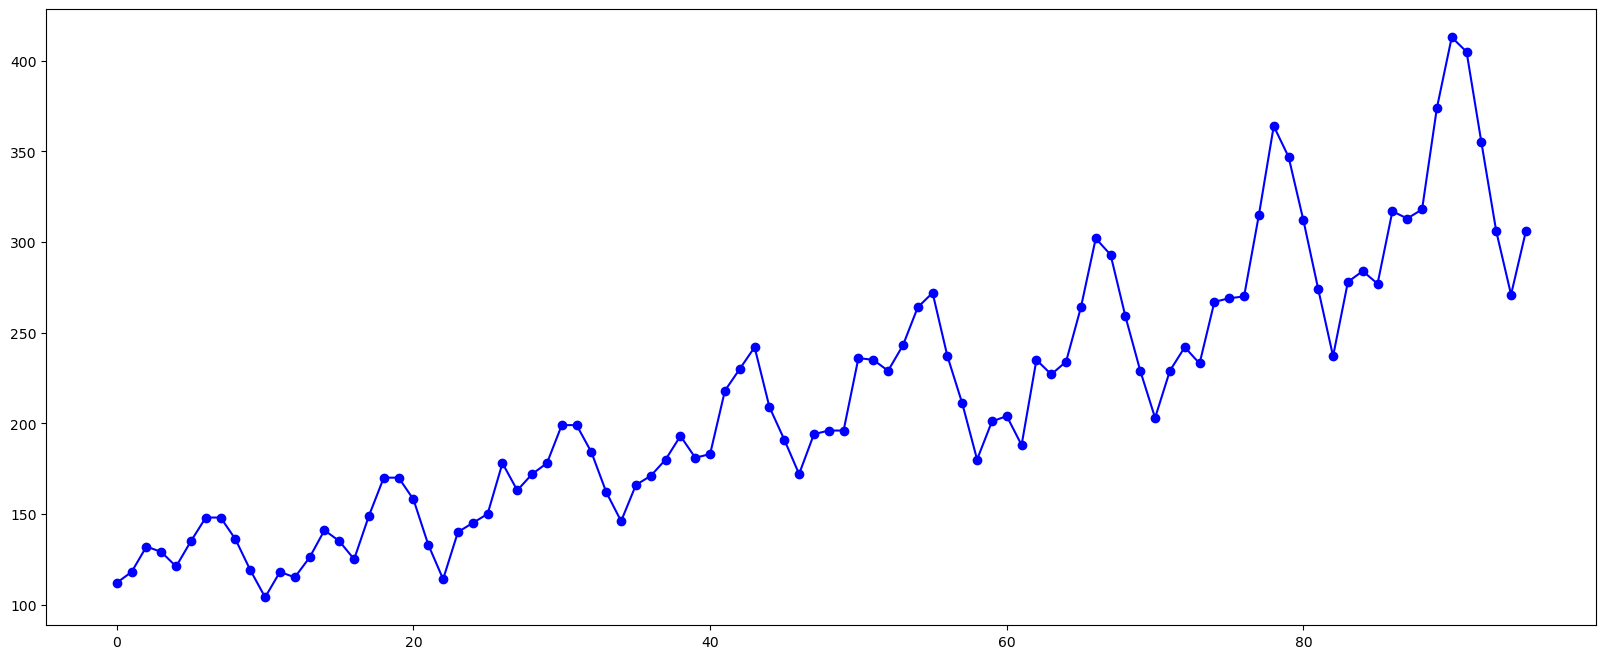

In [12]:
air['Passengers'].plot(figsize=(20, 8),color='blue',marker='o')  

# We can observe increasing trend in passengers

<AxesSubplot:xlabel='year', ylabel='Passengers'>

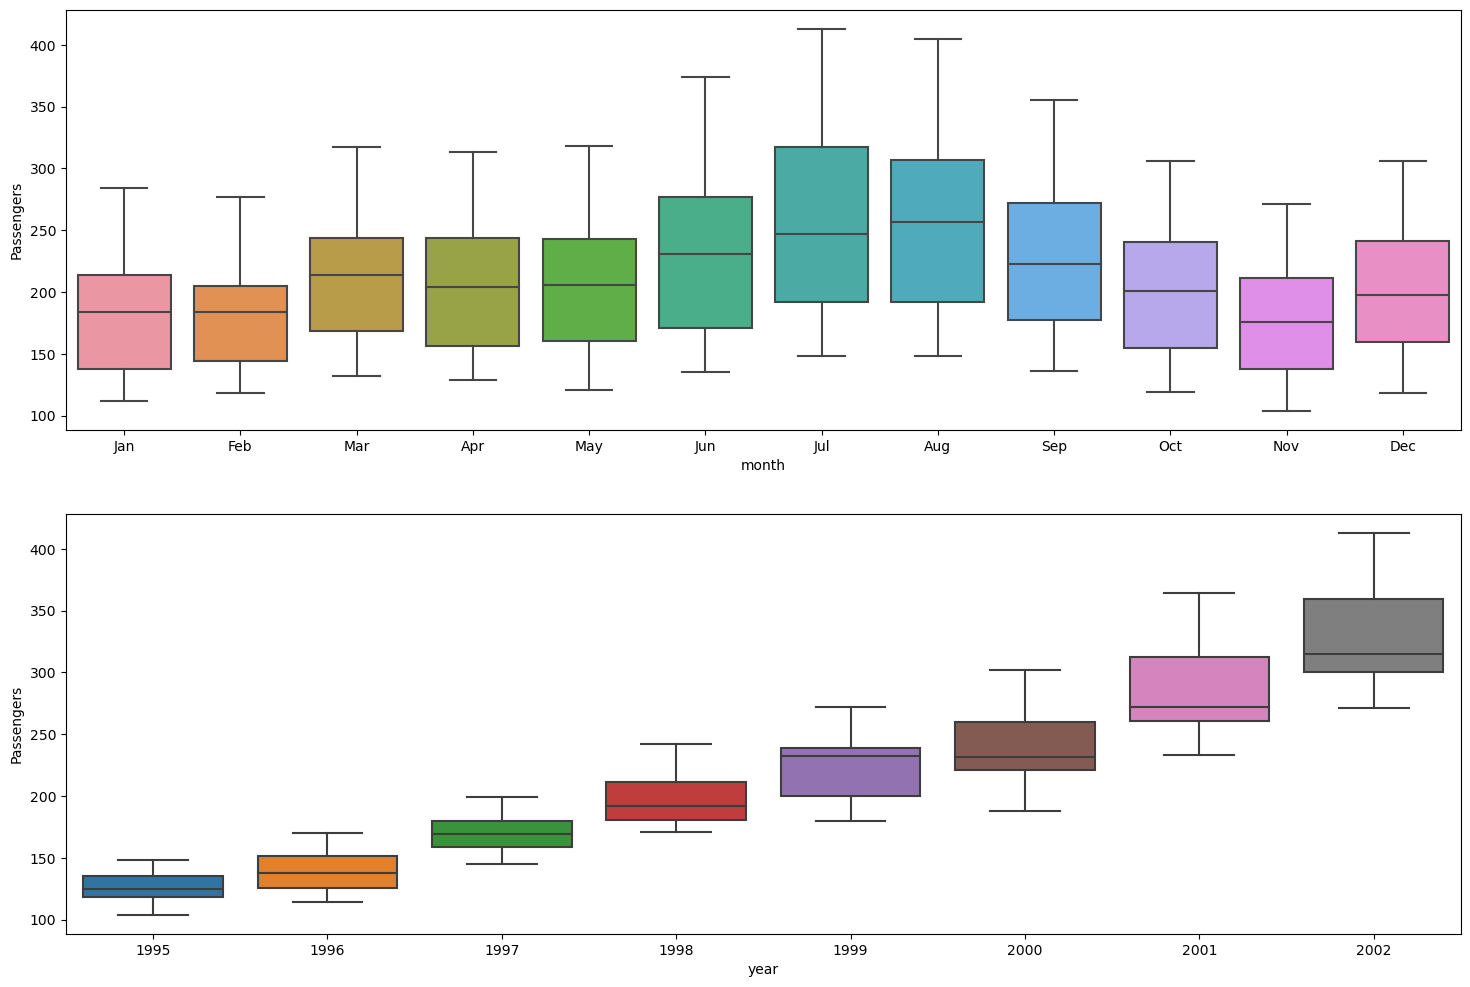

In [13]:

plt.figure(figsize=(18,12))

plt.subplot(2,1,1)
sns.boxplot(air.month, air.Passengers)
plt.subplot(2,1,2)
sns.boxplot(air.year, air.Passengers)

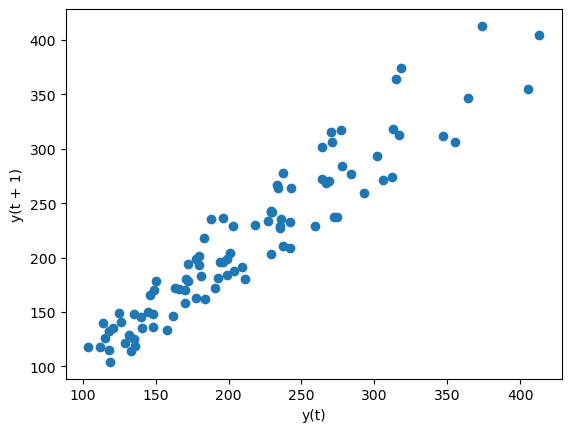

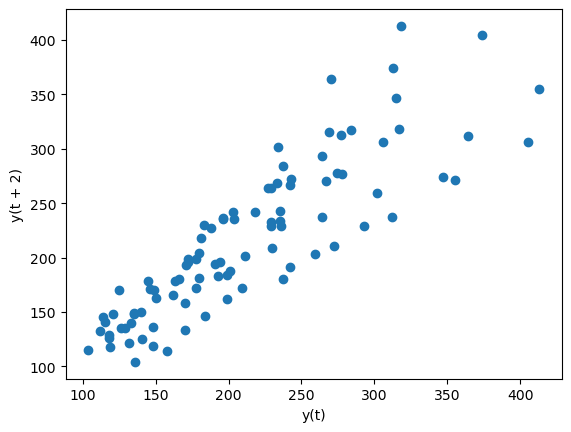

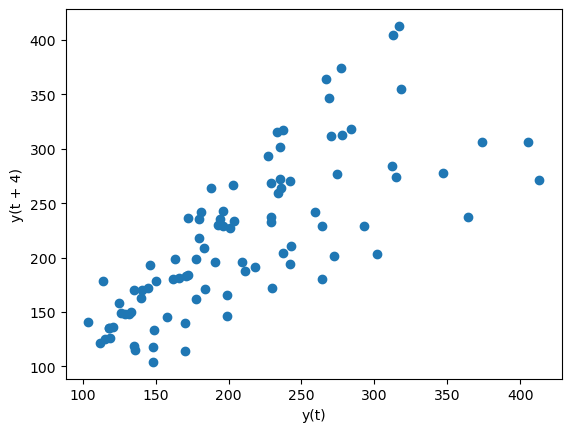

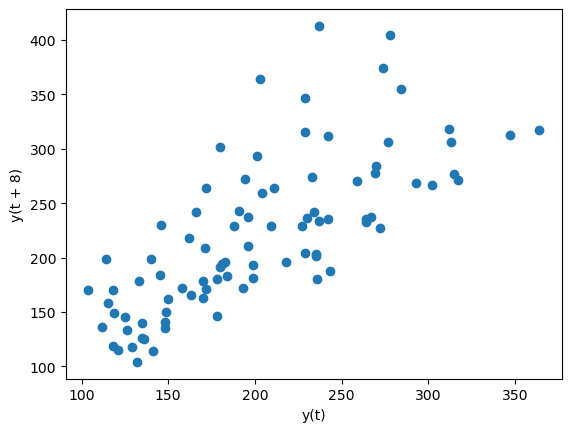

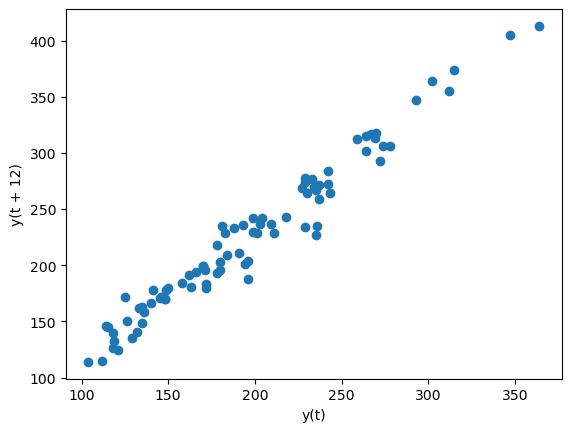

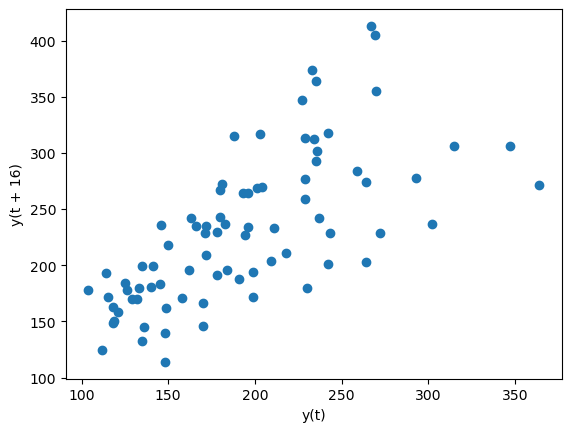

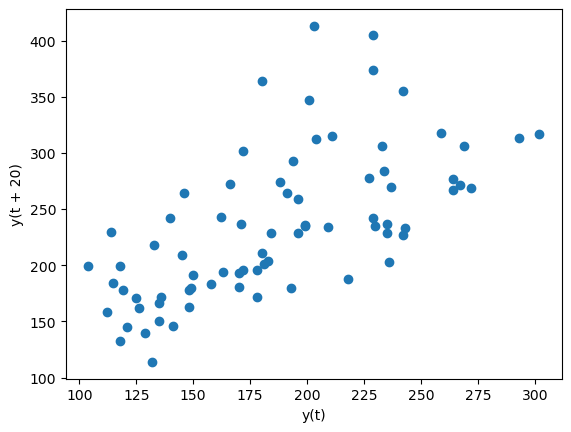

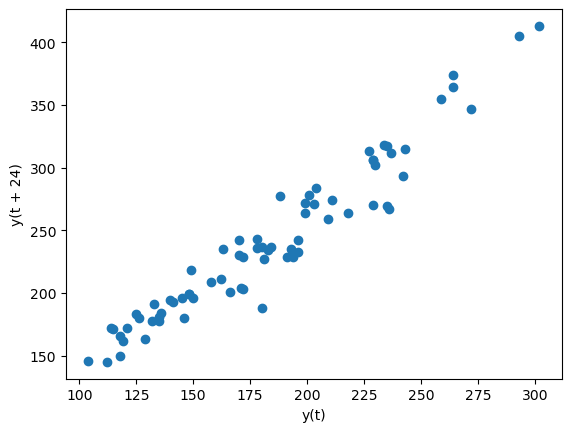

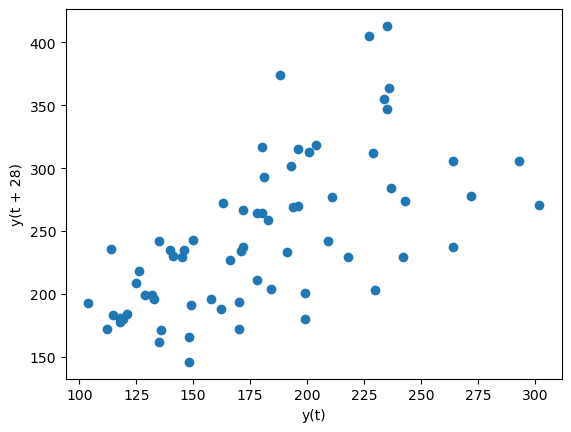

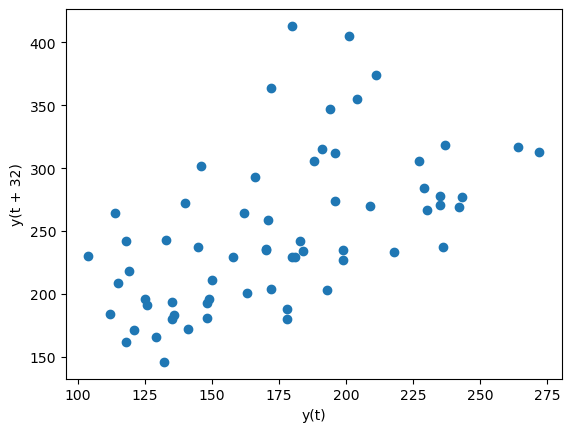

In [14]:

#Lag plot
from pandas.plotting import lag_plot

for i in [1, 2, 4, 8, 12, 16, 20, 24, 28, 32]:
    lag_plot(air.Passengers, lag=i)
    plt.show() 

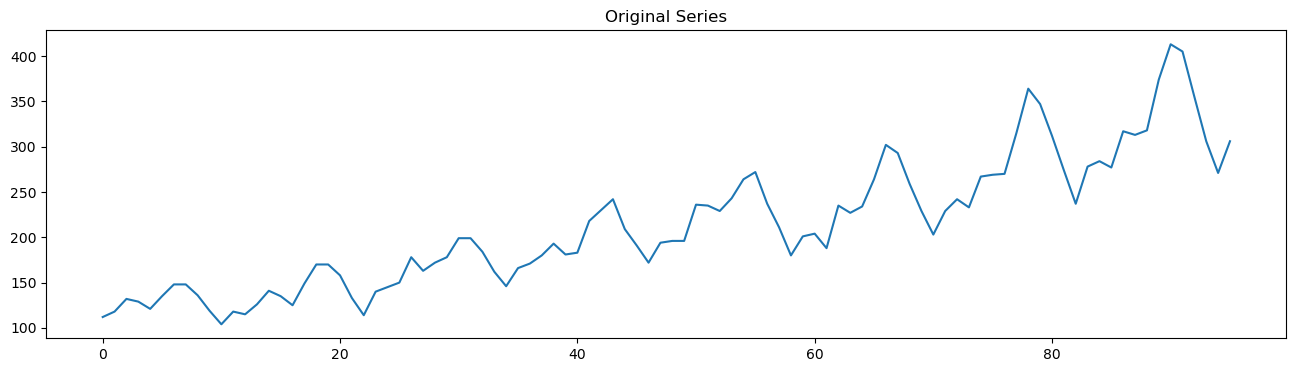

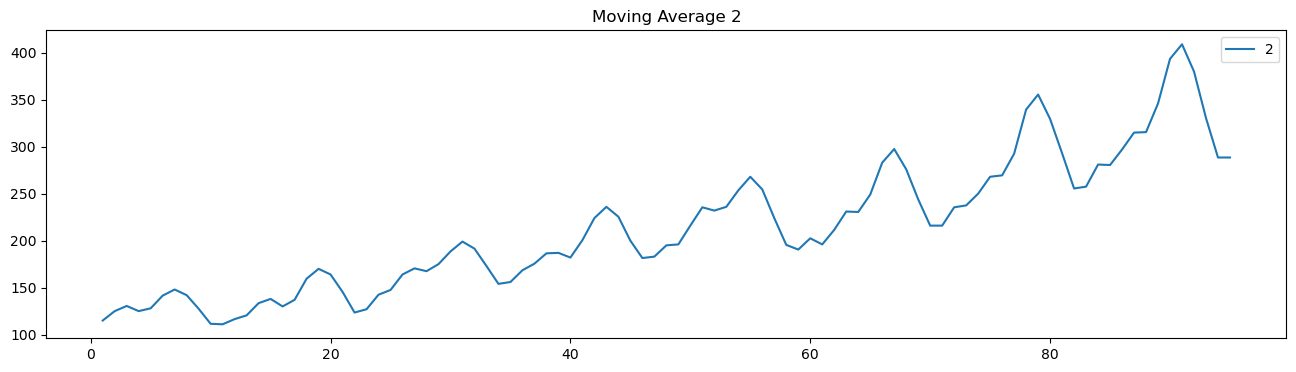

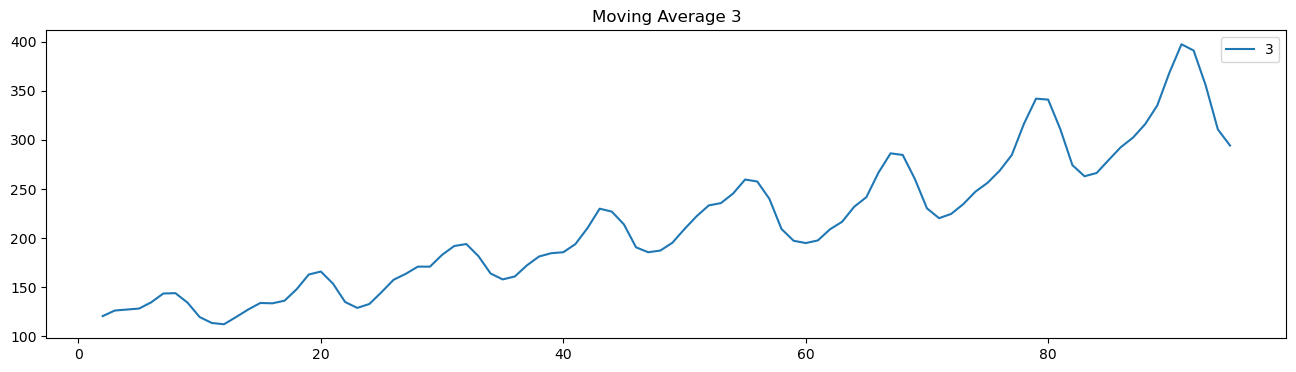

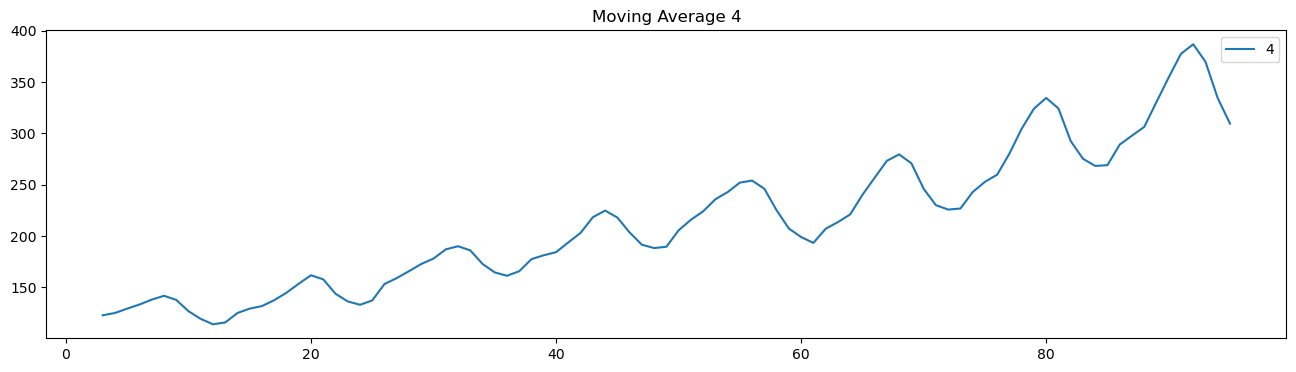

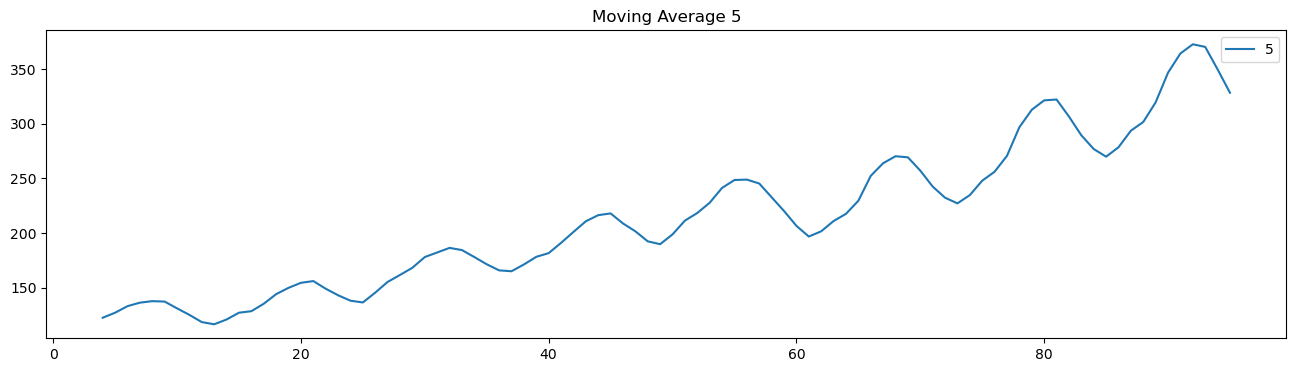

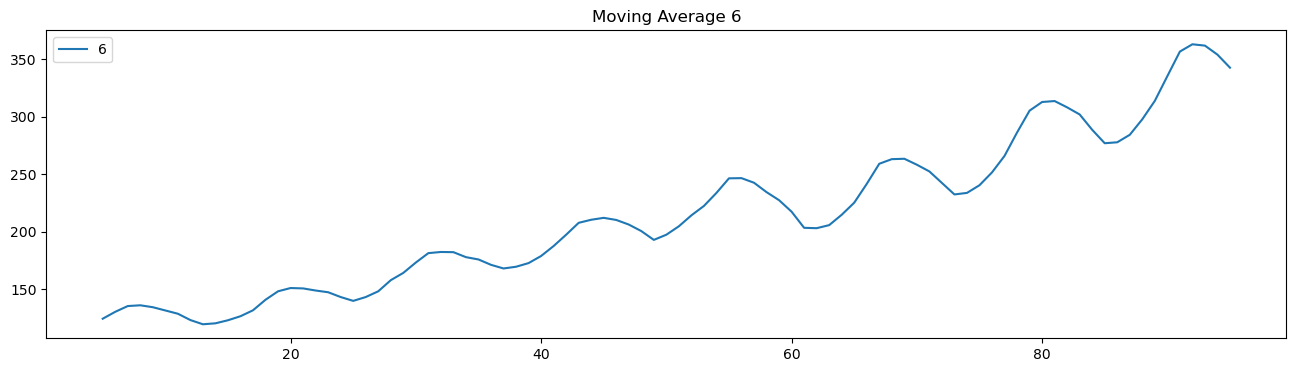

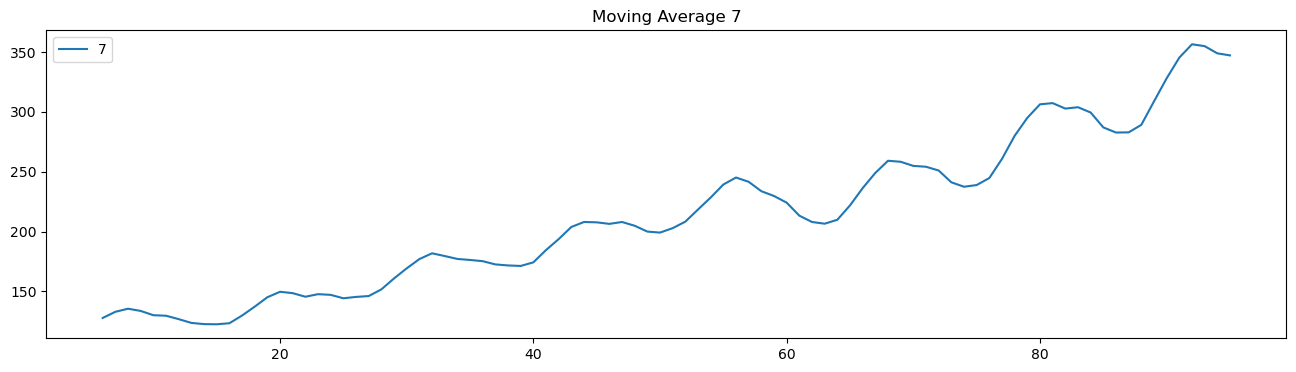

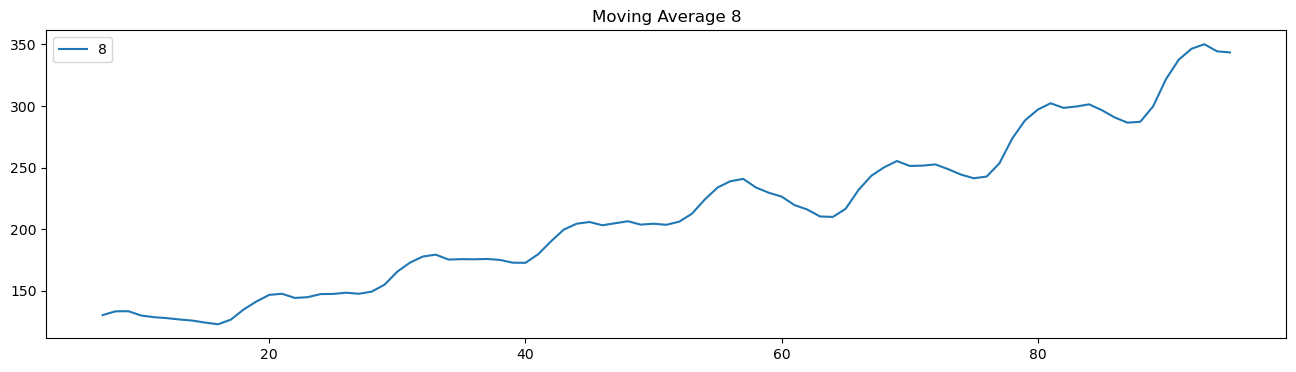

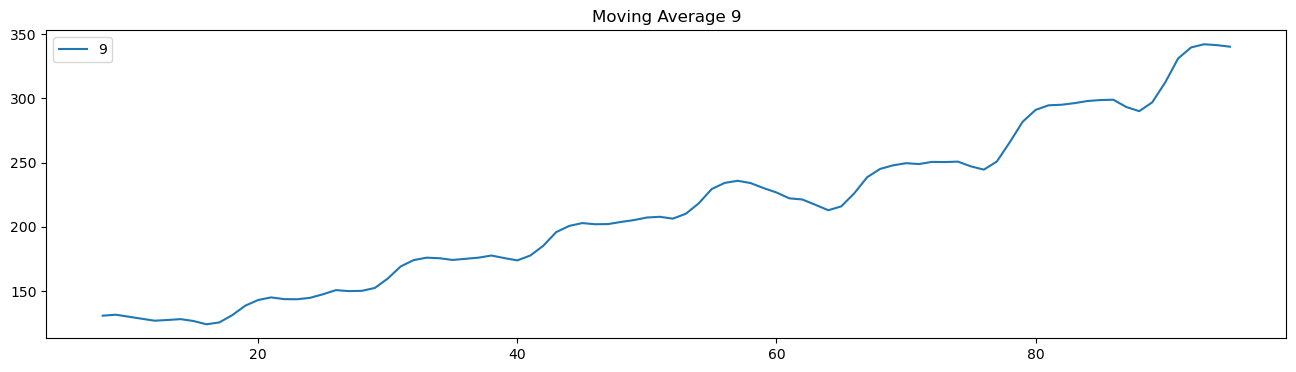

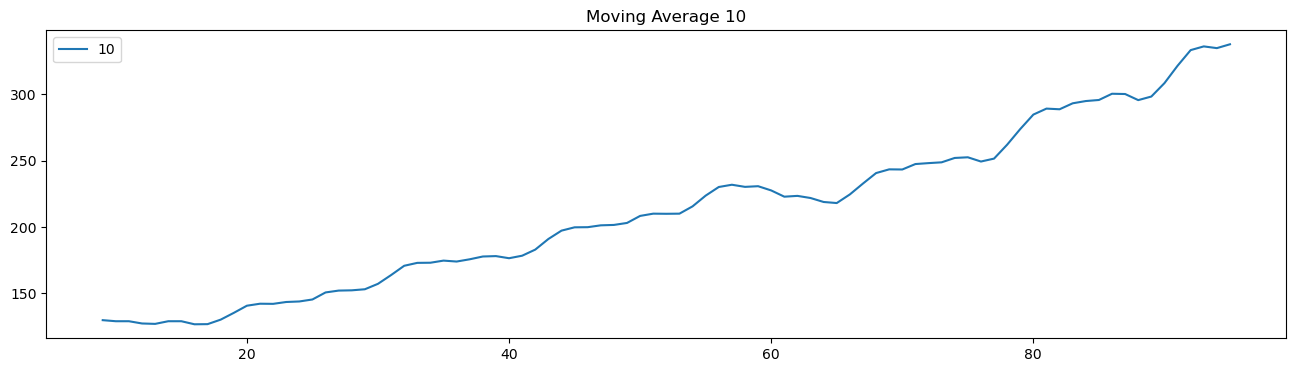

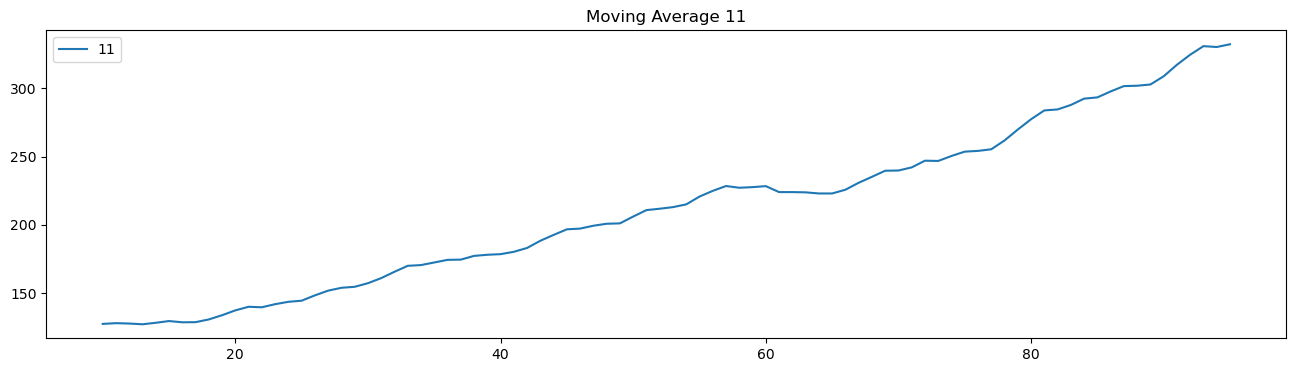

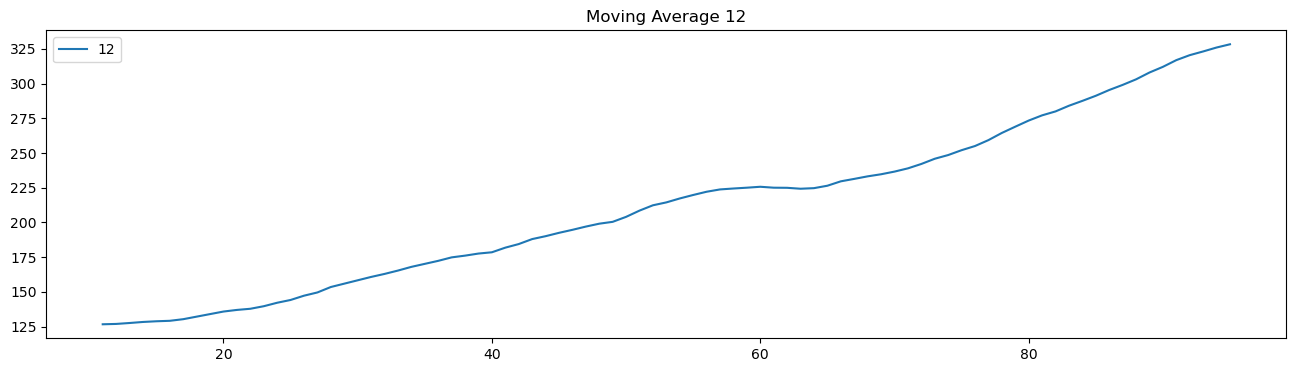

In [15]:

# Moving Average

plt.figure(figsize=(16,4))
air.Passengers.plot(label="org")
plt.title("Original Series")
for i in range(2,13):
    plt.figure(figsize=(16,4))
    air["Passengers"].rolling(i).mean().plot(label=str(i))
    plt.title("Moving Average "+str(i))
    plt.legend(loc='best')
    plt.show() 


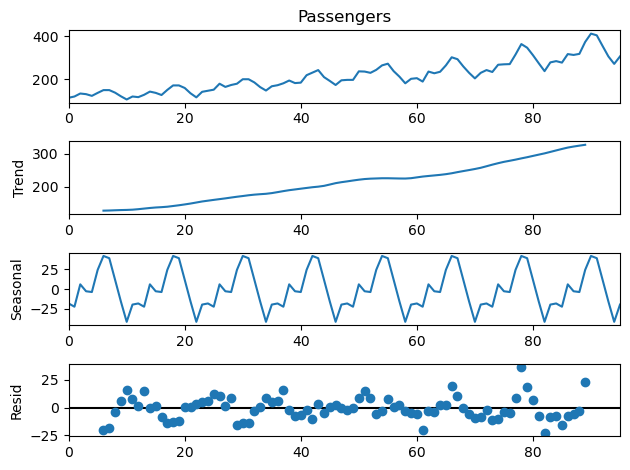

In [16]:

#Time series decomposition plot
from statsmodels.tsa.seasonal import seasonal_decompose 

decompose_ts_add = seasonal_decompose(air.Passengers,period=12)
decompose_ts_add.plot()
plt.show()
     

# ACF plots and PACF plots:

The autocorrelation function (ACF) is a statistical technique that we can use to identify how correlated the values in a time series are with each other. The ACF plots the correlation coefficient against the lag, which is measured in terms of a number of periods or units.

The correlation coefficient can range from -1 (a perfect negative relationship) to +1 (a perfect positive relationship). A coefficient of 0 means that there is no relationship between the variables.

Partial autocorrelation is a statistical measure that captures the correlation between two variables after controlling for the effects of other variables.

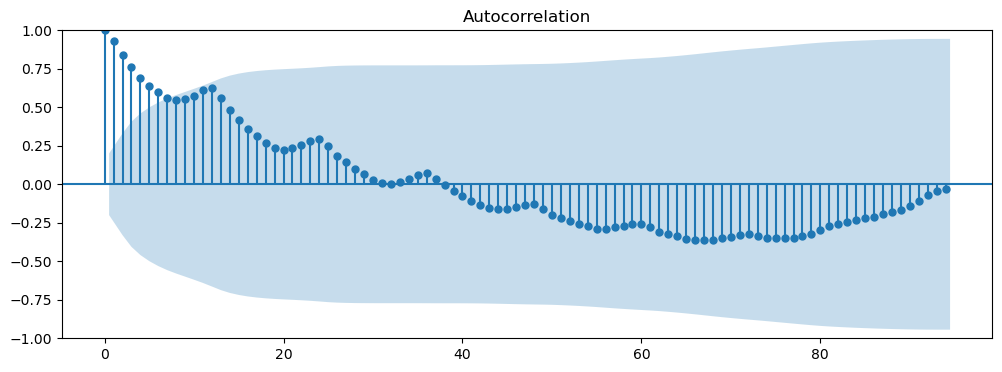

In [17]:
import statsmodels.graphics.tsaplots as tsa_plots
plt.rc("figure", figsize=(12,4)) 
tsa_plots.plot_acf(air.Passengers,lags=94)
plt.show()

Notice that for a lag zero, ACF is always equal to one, which makes sense because the signal is always perfectly correlated with itself.

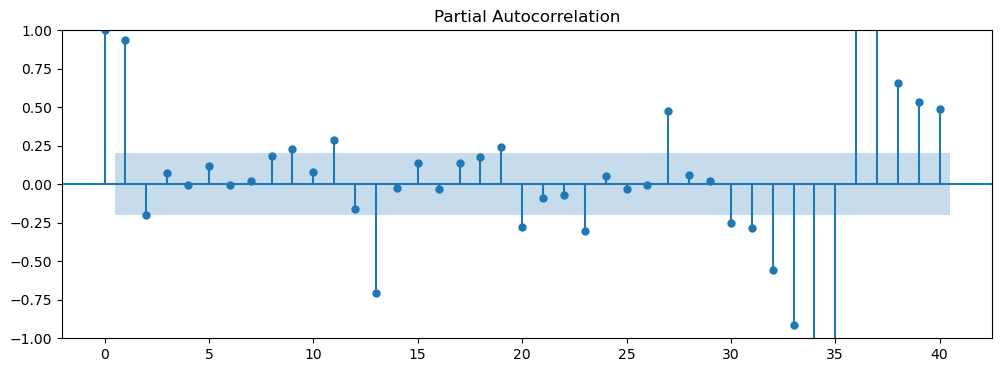

In [18]:

plt.rc("figure", figsize=(12,4))
tsa_plots.plot_pacf(air.Passengers,lags=40)
plt.show()

Forecasting: Model based methods

In [19]:
Train = air1.head(72)
Test = air1.tail(24) 

In [20]:

#Linear Model
import statsmodels.formula.api as smf 

linear_model = smf.ols('Passengers~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_linear))**2))
rmse_linear 

51.6677929956463

In [21]:

#Exponential

Exp = smf.ols('log_passengers~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp 
     

42.55232894600458

In [22]:

#Quadratic 

Quad = smf.ols('Passengers~t+t_squared',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_Quad))**2))
rmse_Quad
     

51.99073640155462

In [23]:

#Additive seasonality 

add_sea = smf.ols('Passengers ~ month_Apr + month_Aug+  month_Dec+ month_Feb+  month_Jan+  month_Jul+ month_Jun+  month_Mar+  month_May+  month_Nov+  month_Oct+ month_Sep',  data=Train).fit()

pred_add_sea = pd.Series(add_sea.predict(Test[[ 'month_Apr',
       'month_Aug', 'month_Dec', 'month_Feb', 'month_Jan', 'month_Jul',
       'month_Jun', 'month_Mar', 'month_May', 'month_Nov', 'month_Oct',
       'month_Sep']]))
rmse_add_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_add_sea))**2))
rmse_add_sea 

127.26451565320338

In [24]:

#Additive Seasonality Quadratic 

add_sea_Quad = smf.ols('Passengers ~t +t_squared + month_Apr + month_Aug+  month_Dec+ month_Feb+  month_Jan+  month_Jul+ month_Jun+  month_Mar+  month_May+  month_Nov+  month_Oct+ month_Sep',data=Train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(Test[['month_Apr',
       'month_Aug', 'month_Dec', 'month_Feb', 'month_Jan', 'month_Jul',
       'month_Jun', 'month_Mar', 'month_May', 'month_Nov', 'month_Oct',
       'month_Sep','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

35.24160848593327

In [25]:
##Multiplicative Seasonality

Mul_sea = smf.ols('log_passengers ~ month_Apr + month_Aug+  month_Dec+ month_Feb+  month_Jan+  month_Jul+ month_Jun+  month_Mar+  month_May+  month_Nov+  month_Oct+ month_Sep',data = Train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(Test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Mult_sea)))**2))
rmse_Mult_sea 
     

132.1876280026344

In [26]:
#Multiplicative Additive Seasonality 


Mul_Add_sea = smf.ols('log_passengers ~ t+ month_Apr + month_Aug+  month_Dec+ month_Feb+  month_Jan+  month_Jul+ month_Jun+  month_Mar+  month_May+  month_Nov+  month_Oct+ month_Sep',data = Train).fit()
pred_Mult_add_sea = pd.Series(Mul_sea.predict(Test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea 

132.1876280026344

In [27]:

#Compare the results 

data = {"MODEL":pd.Series(["linear","Exp","Quad","add_sea","add_sea_quad","Mult_sea","Mult_add_sea"]),"RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values']) 

,MODEL,RMSE_Values
4,add_sea_quad,35.241608
1,Exp,42.552329
0,linear,51.667793
2,Quad,51.990736
3,add_sea,127.264516
5,Mult_sea,132.187628
6,Mult_add_sea,132.187628


Forecasting: Data Driven Models

In [28]:

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing  
import math  
import sklearn.metrics  

def rmse(actual, pred):
    mse = sklearn.metrics.mean_squared_error(actual, pred)  
    rmse = math.sqrt(mse)
    return rmse 
# Simple Exponential Method
ses_model = SimpleExpSmoothing(Train["Passengers"]).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
rmse_ses = rmse(Test.Passengers, pred_ses) 
rmse_ses 
     

83.65334103034091

In [29]:

# Holt method 
hw_model = Holt(Train["Passengers"]).fit(smoothing_level=0.8, smoothing_slope=0.2)
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
rmse_hw = rmse(Test.Passengers, pred_hw) 
rmse_hw 

148.1869009913758

In [30]:
# Holts winter exponential smoothing with additive seasonality and additive trend
hwe_model_add_add = ExponentialSmoothing(Train["Passengers"],seasonal="add",trend="add",seasonal_periods=4).fit() #add the trend to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
rmse_hwe_add_add = rmse(Test.Passengers, pred_hwe_add_add)  
rmse_hwe_add_add

78.31779715809404

In [31]:

# Holts winter exponential smoothing with multiplicative seasonality and additive trend
hwe_model_mul_add = ExponentialSmoothing(Train["Passengers"],seasonal="mul",trend="add",seasonal_periods=4).fit() 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0],end = Test.index[-1])
rmse_mul_add =rmse(Test.Passengers, pred_hwe_mul_add) 
rmse_mul_add

79.01646911211257

In [32]:

#Compare the results 

data = {"MODEL":pd.Series(["linear","Exp","Quad","add_sea","add_sea_quad","Mult_sea","Mult_add_sea",'ses_model', 'hw_model', 'hwe_model_add_add', 'hwe_model_mul_add']),
        "RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea, rmse_ses, rmse_hw,rmse_hwe_add_add,rmse_mul_add  ])}
table_rmse=pd.DataFrame(data) 
table_rmse = table_rmse.sort_values(by=['RMSE_Values']) 
table_rmse  
     

,MODEL,RMSE_Values
4,add_sea_quad,35.241608
1,Exp,42.552329
0,linear,51.667793
2,Quad,51.990736
9,hwe_model_add_add,78.317797
10,hwe_model_mul_add,79.016469
7,ses_model,83.653341
3,add_sea,127.264516
5,Mult_sea,132.187628
6,Mult_add_sea,132.187628


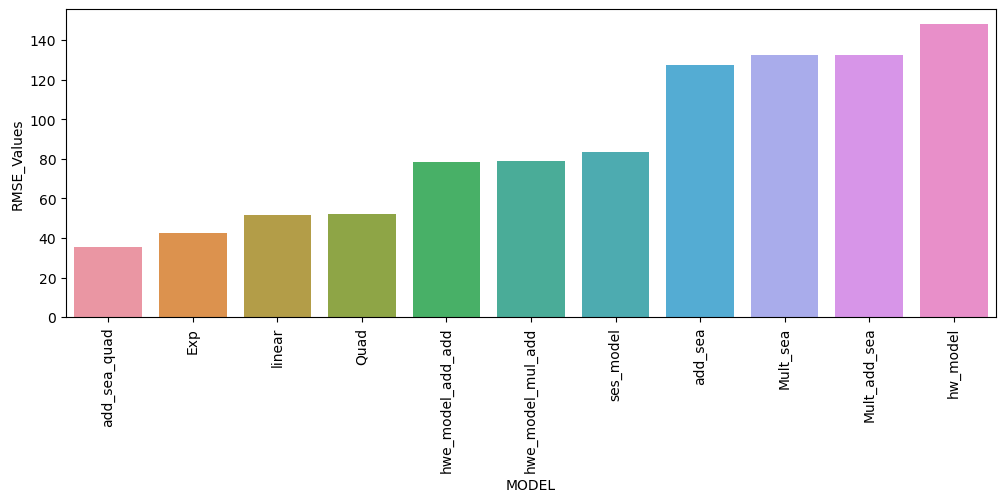

In [33]:

sns.barplot(table_rmse.MODEL , table_rmse.RMSE_Values)
plt.xticks(rotation = 90)
plt.show() 

# Final Model by combining train and test

In [34]:

add_sea_Quad = smf.ols('Passengers ~t +t_squared + month_Apr + month_Aug+  month_Dec+ month_Feb+  month_Jan+  month_Jul+ month_Jun+  month_Mar+  month_May+  month_Nov+  month_Oct+ month_Sep',data=air1).fit()
pred= add_sea_Quad.predict(air1.tail()) #predicting on historic data 
forecast_df = pd.DataFrame()

forecast_df['actual_passengers'] = air1.Passengers.tail()
forecast_df['Predicted_passengers'] = np.round(pred, 0)

forecast_df  

,actual_passengers,Predicted_passengers
91,405,371.0
92,355,344.0
93,306,317.0
94,271,293.0
95,306,319.0


In [35]:

#creating new inputs for forecasting
new_df = pd.DataFrame() 
new_df['t'] = np.arange(97,109,1) 
new_df['t_squared'] = np.square(new_df.t)
new_df['month'] = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'] 
new_df = pd.get_dummies(new_df)
new_df.head()

,t,t_squared,month_Apr,month_Aug,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep
0,97,9409,0,0,0,0,1,0,0,0,0,0,0,0
1,98,9604,0,0,0,1,0,0,0,0,0,0,0,0
2,99,9801,0,0,0,0,0,0,0,1,0,0,0,0
3,100,10000,1,0,0,0,0,0,0,0,0,0,0,0
4,101,10201,0,0,0,0,0,0,0,0,1,0,0,0


In [36]:

add_sea_Quad = smf.ols('Passengers ~t +t_squared + month_Apr + month_Aug+  month_Dec+ month_Feb+  month_Jan+  month_Jul+ month_Jun+  month_Mar+  month_May+  month_Nov+  month_Oct+ month_Sep',data=air1).fit()
pred= add_sea_Quad.predict(new_df) 

new_df['forcasted'] = pred

new_df 

,t,t_squared,month_Apr,month_Aug,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep,forcasted
0,97,9409,0,0,0,0,1,0,0,0,0,0,0,0,328.328687
1,98,9604,0,0,0,1,0,0,0,0,0,0,0,0,329.438178
2,99,9801,0,0,0,0,0,0,0,1,0,0,0,0,359.547668
3,100,10000,1,0,0,0,0,0,0,0,0,0,0,0,354.907159
4,101,10201,0,0,0,0,0,0,0,0,1,0,0,0,356.141650
5,102,10404,0,0,0,0,0,0,1,0,0,0,0,0,385.376141
6,103,10609,0,0,0,0,0,1,0,0,0,0,0,0,413.360631
7,104,10816,0,1,0,0,0,0,0,0,0,0,0,0,412.845122
8,105,11025,0,0,0,0,0,0,0,0,0,0,0,1,385.829613
9,106,11236,0,0,0,0,0,0,0,0,0,0,1,0,358.939103


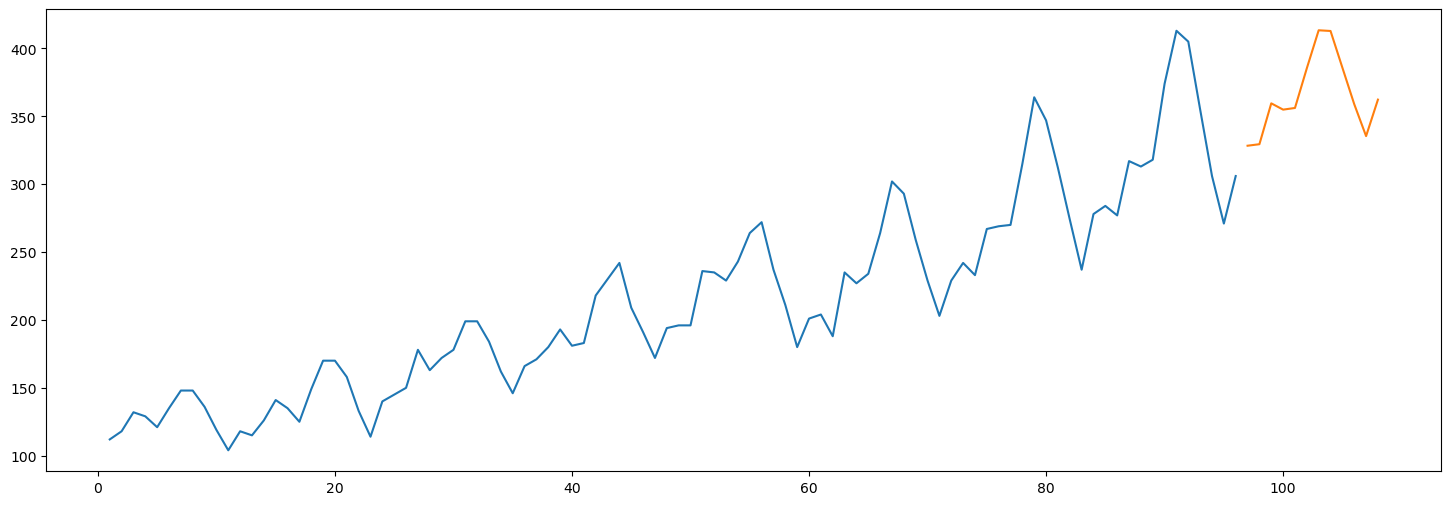

In [37]:

plt.figure(figsize=(18,6))
plt.plot(air1.t , air1.Passengers)
plt.plot(new_df.t , new_df.forcasted) 

# We created dummy variables for Month feature and final model is based on Additive seasonality Quadratic.

# Forecast the CocaCola prices. Prepare a document for each model explaining how many dummy variables you have created and RMSE value for each model. Finally which model you will use for Forecasting.

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

import warnings
warnings.filterwarnings("ignore")

In [40]:

coke = pd.read_excel(r"F:\Data Science\Assignments\18. Forcasting\CocaCola_Sales_Rawdata.xlsx")
coke.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


# Descriptive Statistics

In [41]:
coke.isna().sum()
     

Quarter    0
Sales      0
dtype: int64

In [42]:

coke.duplicated().sum()

0

In [43]:

coke.shape

(42, 2)

In [44]:
coke.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 800.0+ bytes


# Feature Engineering

In [45]:

quarter = []
for i in range (0, len(coke)):
    if 'Q1' in coke.Quarter[i]:
        quarter.append('Q1')
    elif 'Q2' in coke.Quarter[i]:
        quarter.append('Q2')
    elif 'Q3' in coke.Quarter[i]:
        quarter.append('Q3')
    elif 'Q4' in coke.Quarter[i]:
        quarter.append('Q4') 
        
coke['quarter'] = quarter 
year = []

for i in range (0, len(coke)):
    year.append(int(coke.Quarter[i].replace(coke.Quarter[i][:3], ''))) 
    
coke['year'] = year 
coke.drop('Quarter', axis=1, inplace=True)
coke['log_sales'] = np.log(coke.Sales)
coke['t'] = np.arange(1,len(coke)+1) 
coke['t_squared'] = coke.t * coke.t 
coke1 = coke[['t', 't_squared', 'quarter', 'year', 'Sales', 'log_sales']] 
coke1 = pd.get_dummies(coke1) 
coke1.head()

,t,t_squared,year,Sales,log_sales,quarter_Q1,quarter_Q2,quarter_Q3,quarter_Q4
0,1,1,86,1734.827000,7.458663,1,0,0,0
1,2,4,86,2244.960999,7.716443,0,1,0,0
2,3,9,86,2533.804993,7.837477,0,0,1,0
3,4,16,86,2154.962997,7.675529,0,0,0,1
4,5,25,87,1547.818996,7.344602,1,0,0,0


# Data Visualization

<AxesSubplot:>

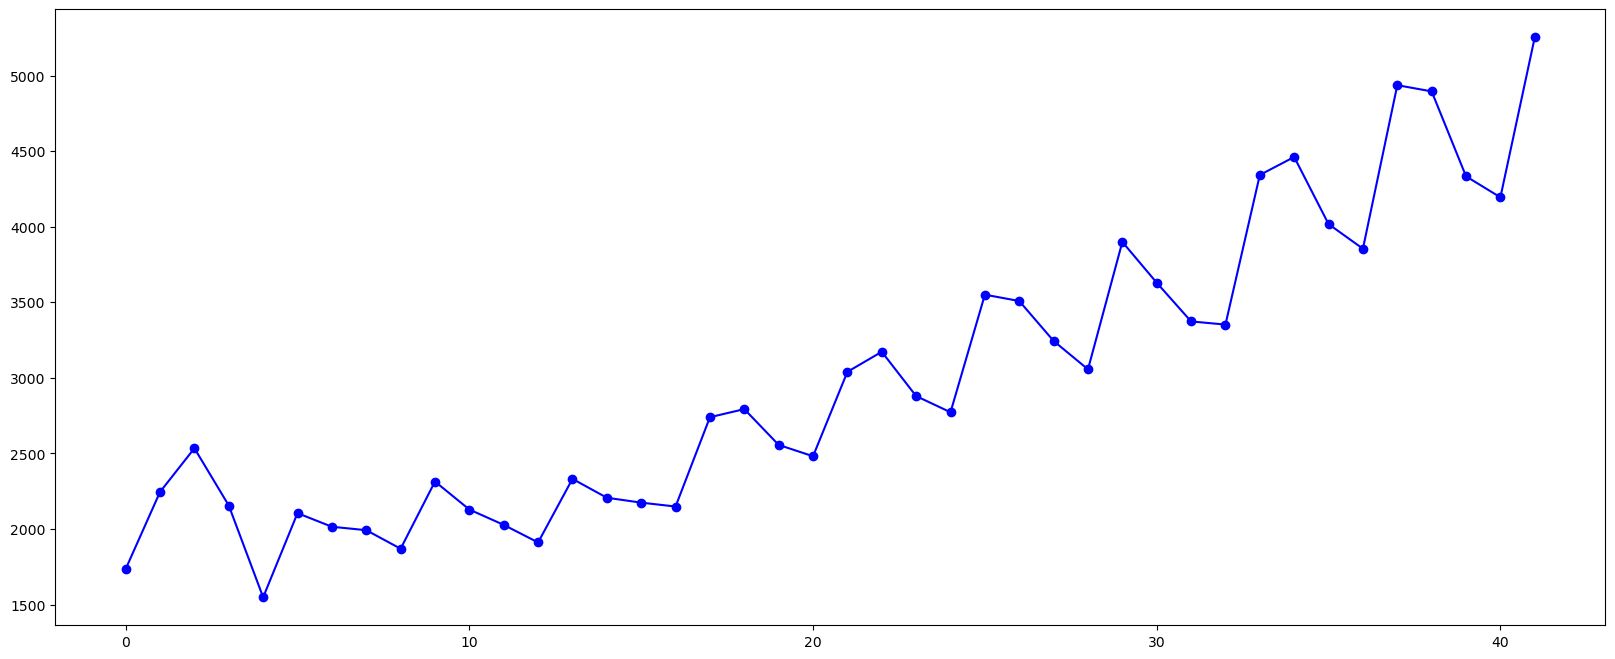

In [46]:
coke1.Sales.plot(figsize=(20, 8),color='blue',marker='o') 

<AxesSubplot:xlabel='year', ylabel='Sales'>

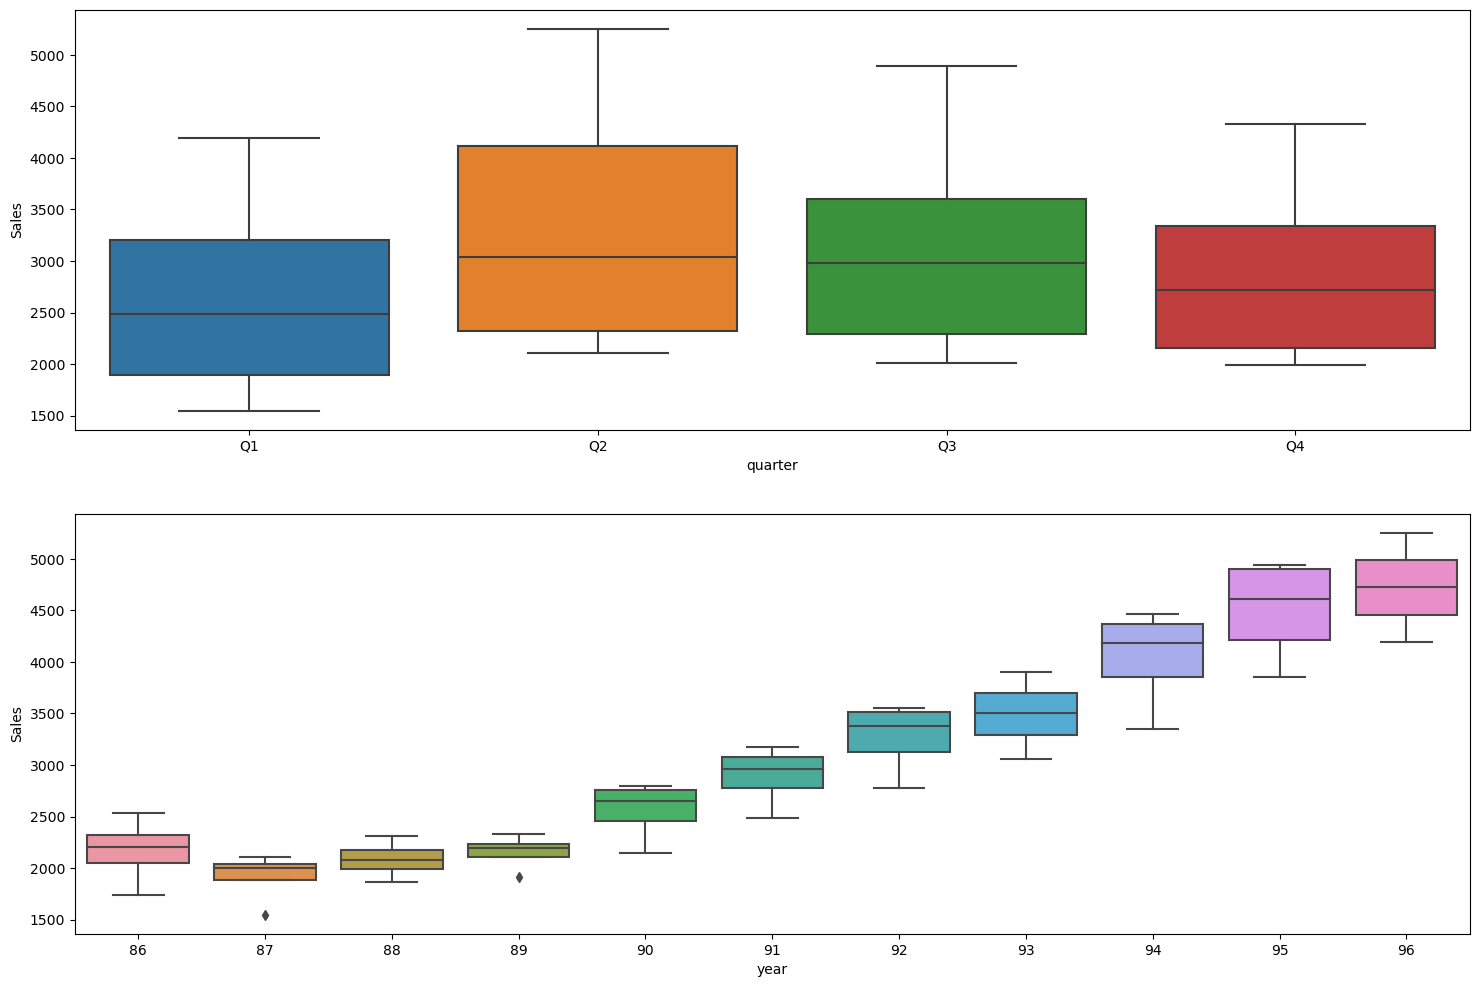

In [47]:
plt.figure(figsize=(18,12))

plt.subplot(2,1,1)
sns.boxplot(coke.quarter, coke.Sales)
plt.subplot(2,1,2)
sns.boxplot(coke.year, coke.Sales)

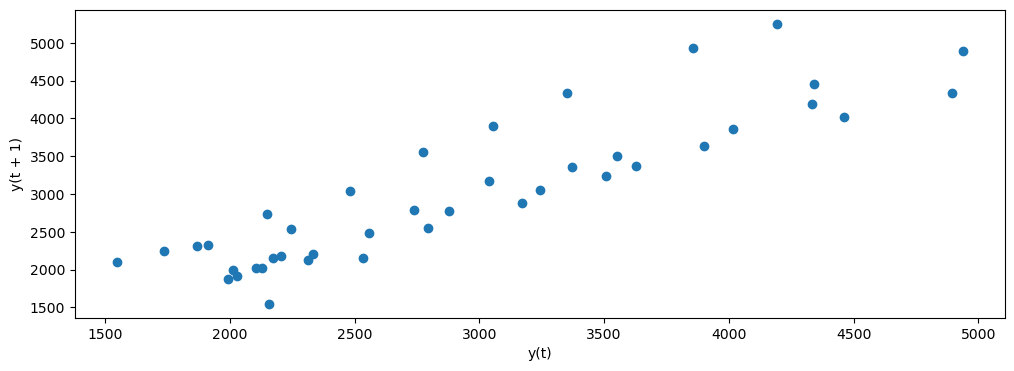

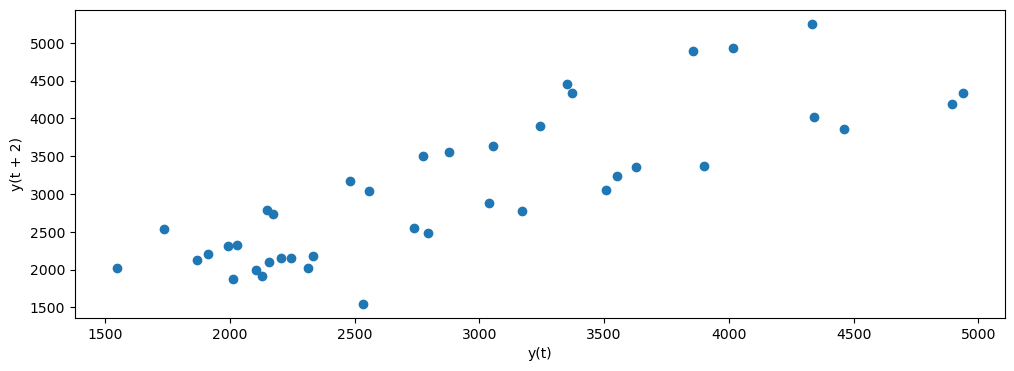

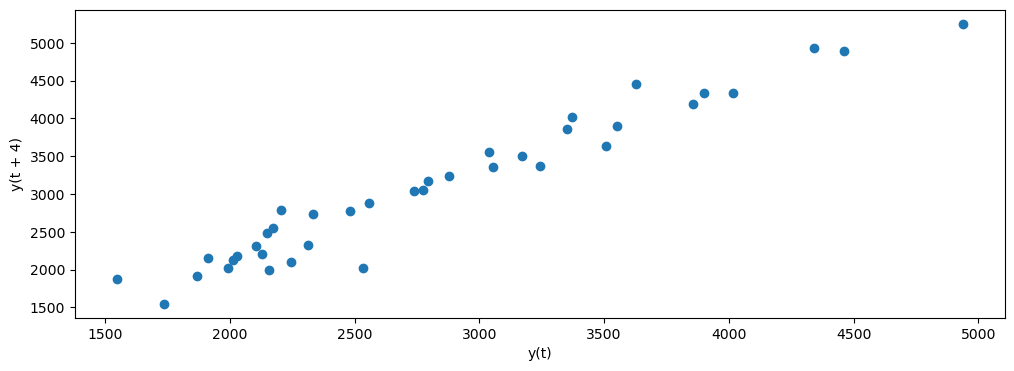

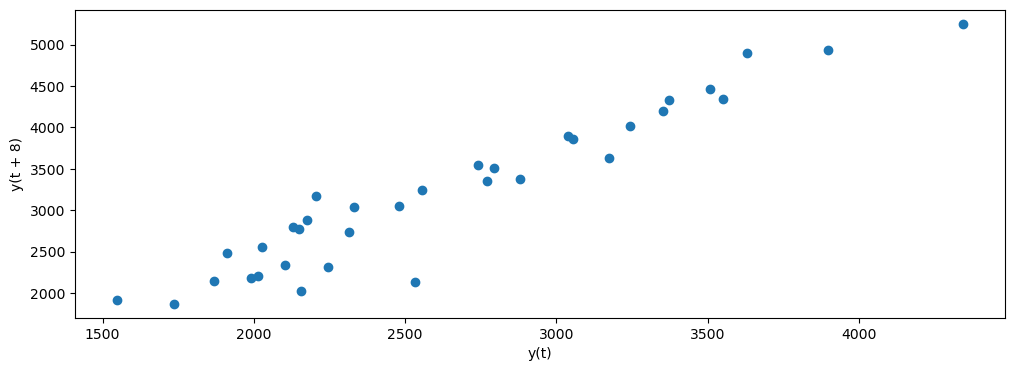

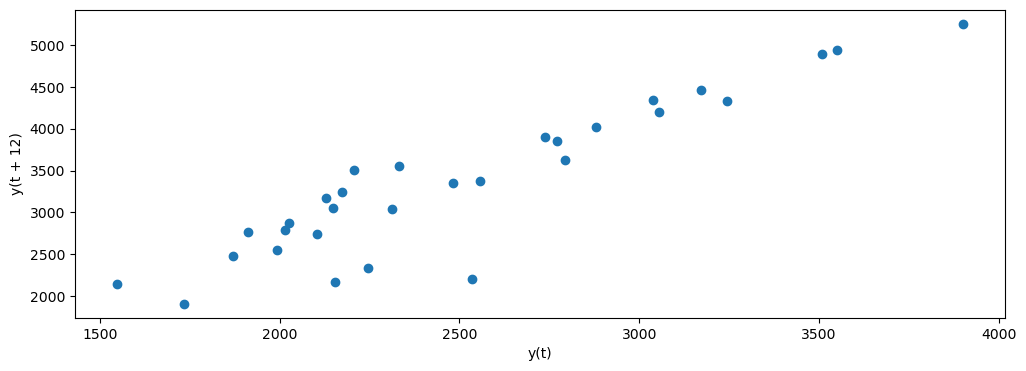

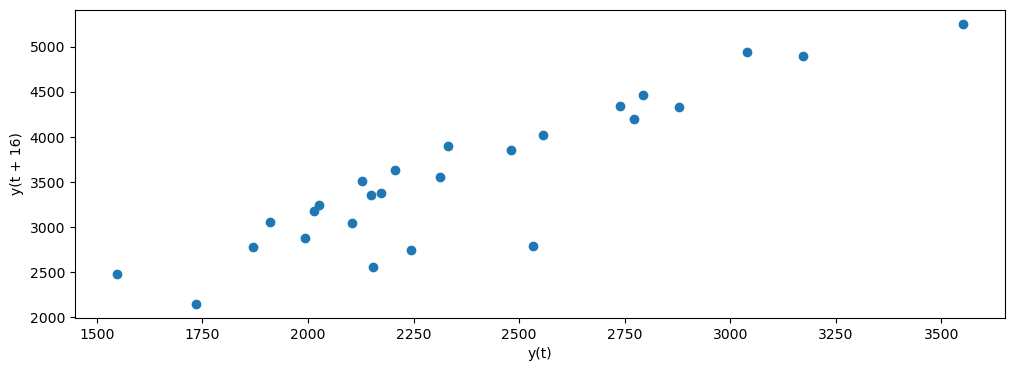

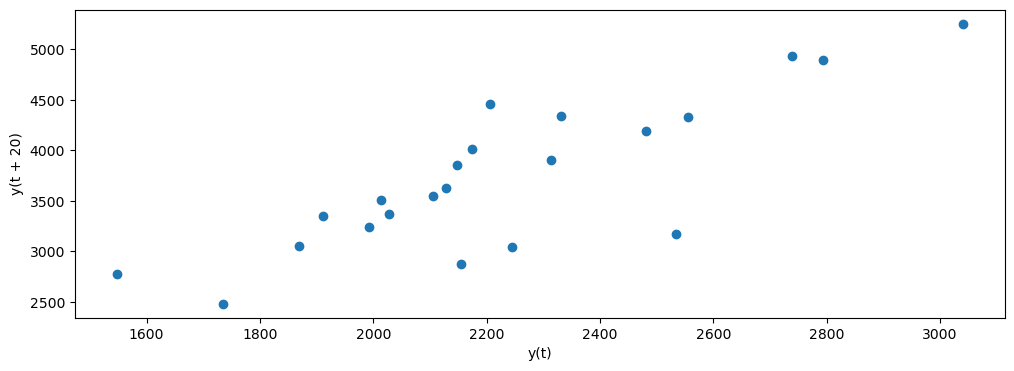

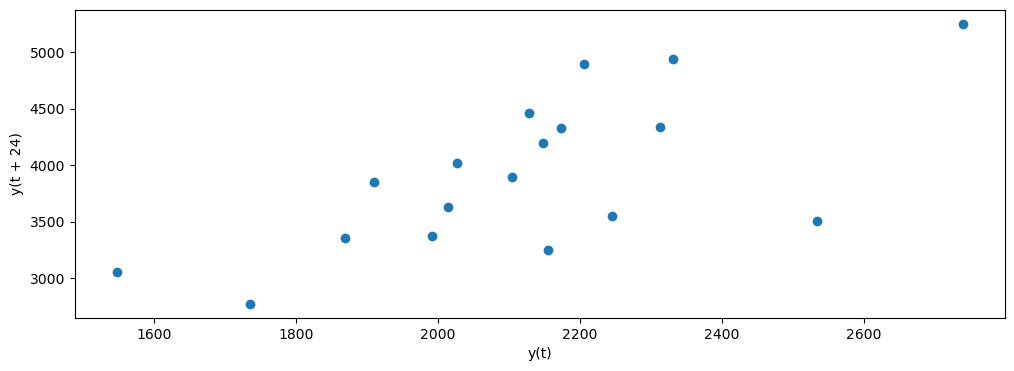

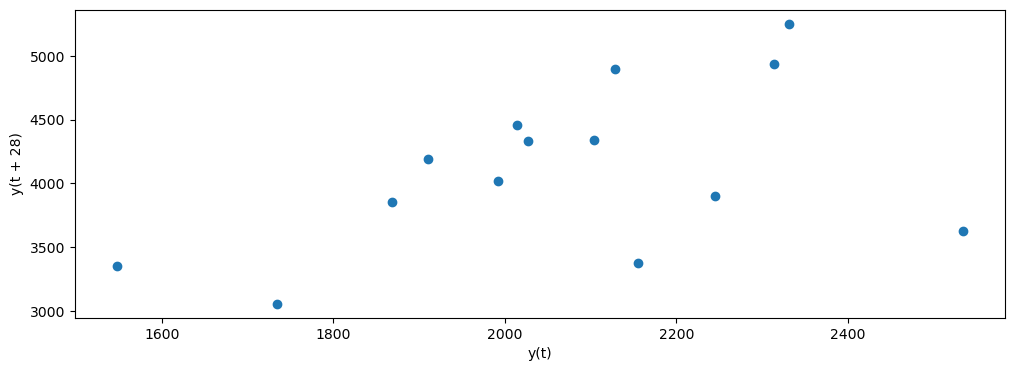

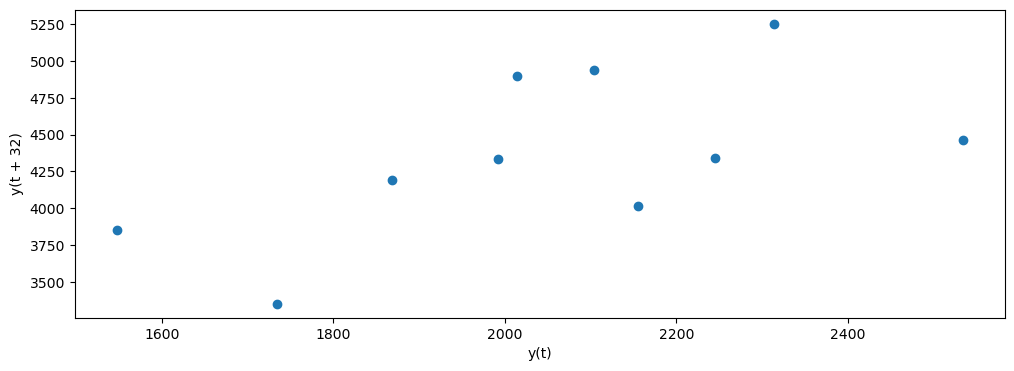

In [48]:

#Lag plot
from pandas.plotting import lag_plot

for i in [1, 2, 4, 8, 12, 16, 20, 24, 28, 32]:
    lag_plot(coke1.Sales, lag=i)
    plt.show() 

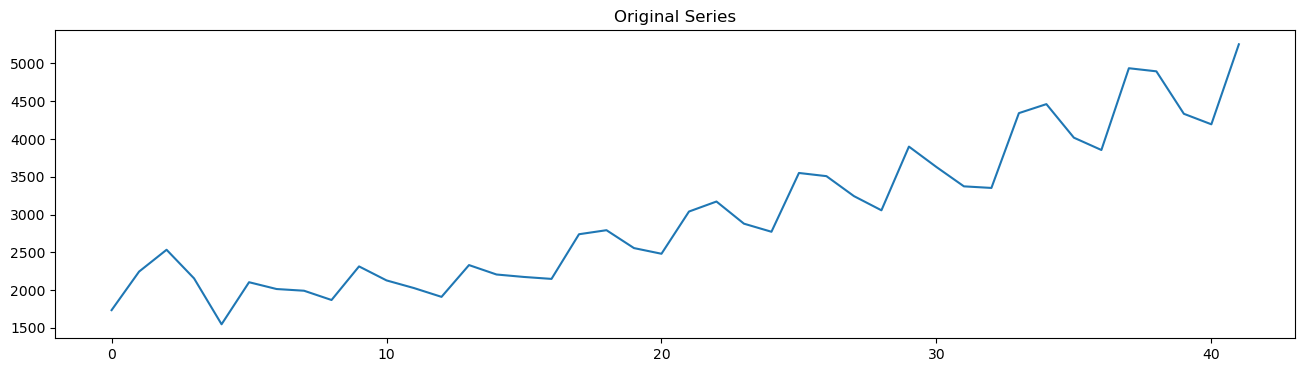

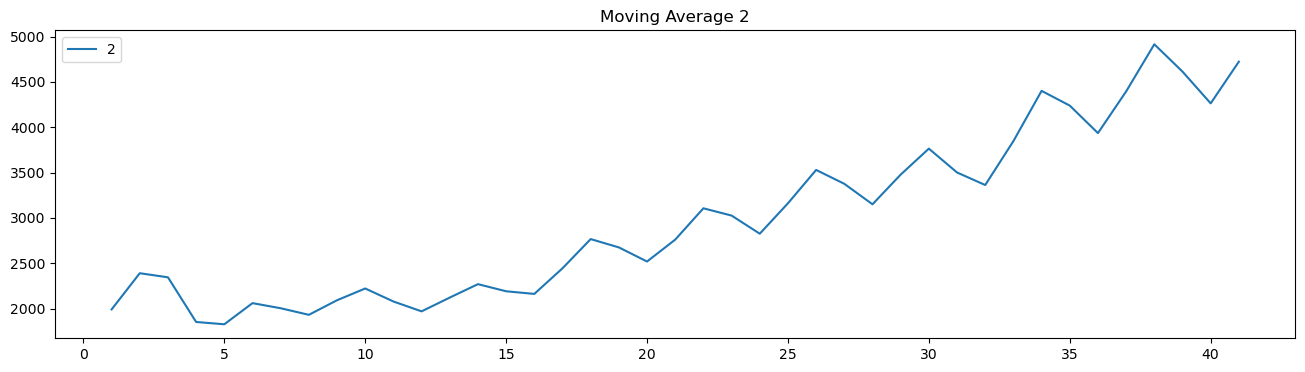

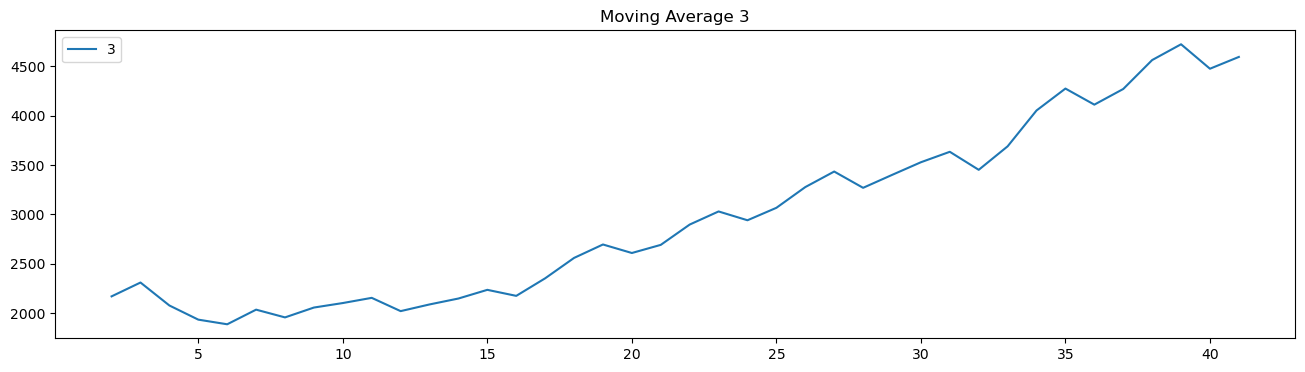

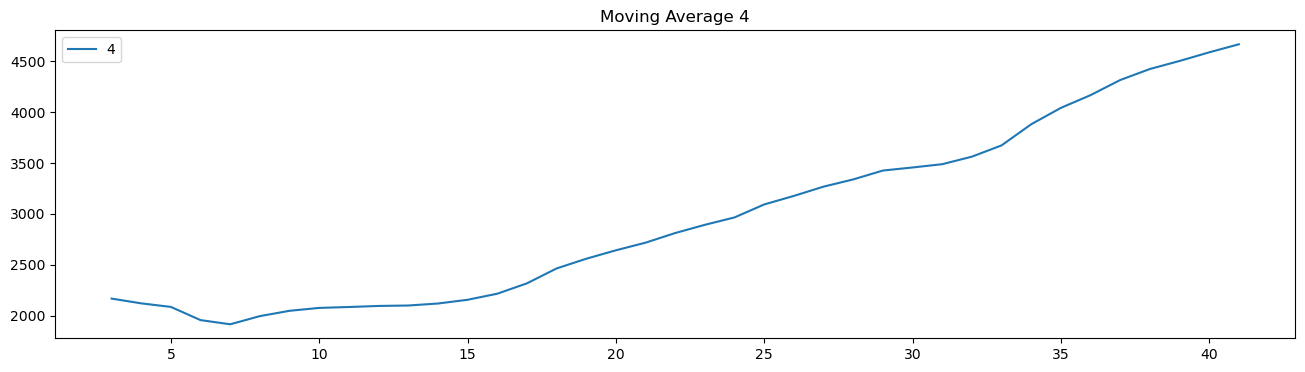

In [49]:

#Moving Average

plt.figure(figsize=(16,4))
coke.Sales.plot(label="org")
plt.title("Original Series")
for i in range(2,5):
    plt.figure(figsize=(16,4))
    coke["Sales"].rolling(i).mean().plot(label=str(i))
    plt.title("Moving Average "+str(i))
    plt.legend(loc='best')
    plt.show() 

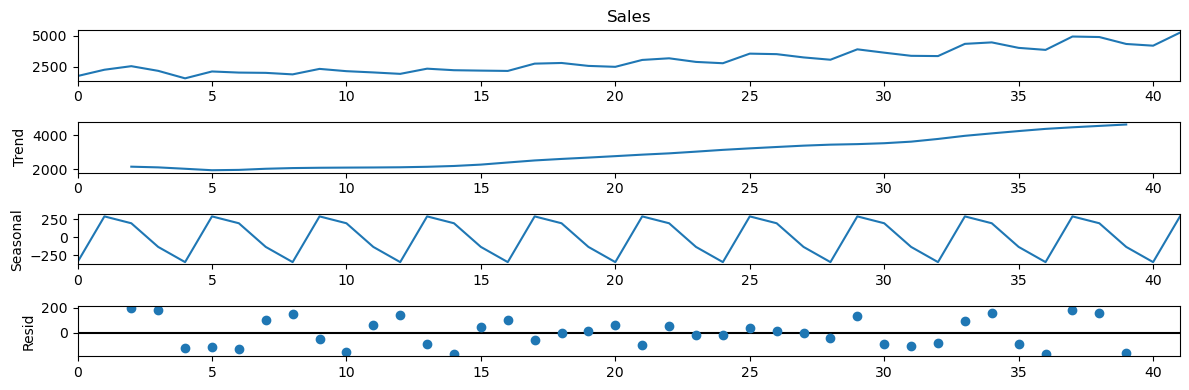

In [50]:

# Time series decomposition plot 
from statsmodels.tsa.seasonal import seasonal_decompose 

decompose_ts_add = seasonal_decompose(coke1.Sales,period=4)
decompose_ts_add.plot()
plt.show()

### There is an upward trend in sales over the time. Though with some ups and downs. Also we can notice ups and downs are a bit regular, it indicates a seasonal pattern.

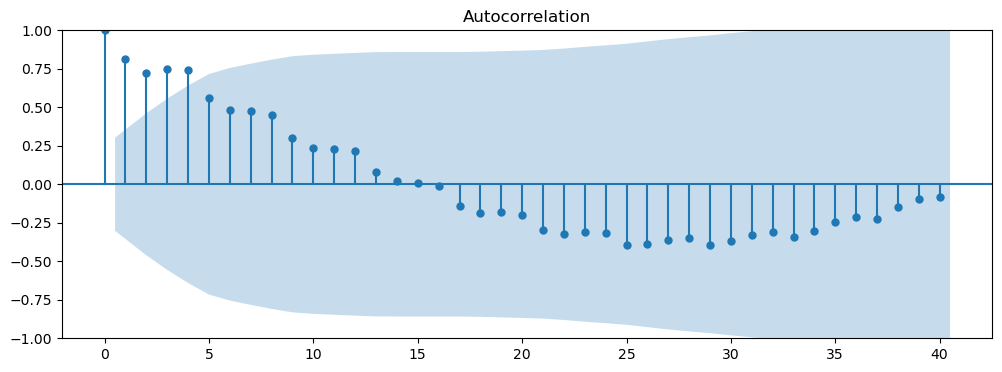

In [51]:

import statsmodels.graphics.tsaplots as tsa_plots
plt.rc("figure", figsize=(12,4)) 
tsa_plots.plot_acf(coke.Sales,lags=40)
plt.show()

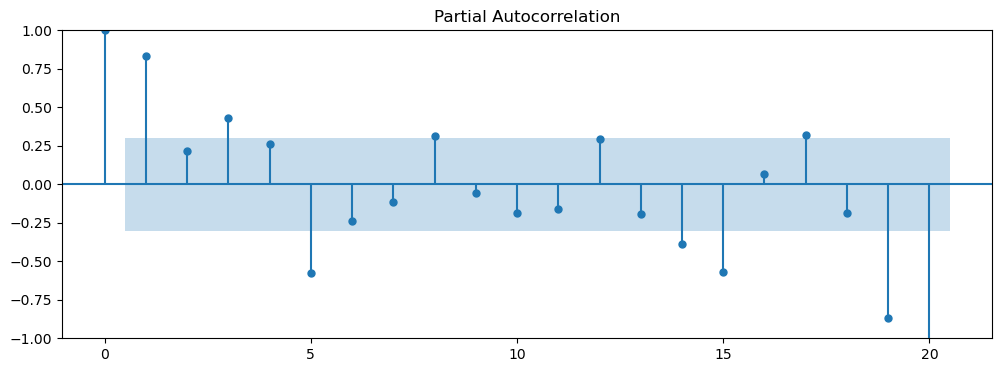

In [52]:
plt.rc("figure", figsize=(12,4))
tsa_plots.plot_pacf(coke.Sales,lags=20)
plt.show()

# Forecasting: Model based methods

In [53]:

Train = coke1.head(32)
Test = coke1.tail(10) 
#Linear Model
import statsmodels.formula.api as smf 

linear_model = smf.ols('Sales~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_linear))**2))
rmse_linear
     

752.9233932767115

In [54]:

#Exponential

Exp = smf.ols('log_sales~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp
     

590.3316432076576

In [55]:

#Quadratic 

Quad = smf.ols('Sales~t+t_squared',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_Quad))**2))
rmse_Quad

457.73573554072897

In [56]:

#Additive seasonality 

add_sea = smf.ols('Sales ~ quarter_Q1 + quarter_Q2+ quarter_Q3+ quarter_Q4',data=Train).fit()
pred_add_sea = pd.Series(add_sea.predict(Test[[ 'quarter_Q1' ,'quarter_Q2','quarter_Q3', 'quarter_Q4']]))
rmse_add_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_add_sea))**2))
rmse_add_sea 

1850.4665461858358

In [57]:

#Additive Seasonality Quadratic 

add_sea_Quad = smf.ols('Sales~t+t_squared+quarter_Q1 + quarter_Q2+ quarter_Q3+ quarter_Q4',data=Train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(Test[['quarter_Q1', 'quarter_Q2', 'quarter_Q3', 'quarter_Q4','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad 

277.35107711286446

In [58]:

##Multiplicative Seasonality

Mul_sea = smf.ols('log_sales~quarter_Q1 + quarter_Q2+ quarter_Q3+ quarter_Q4',data = Train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(Test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Mult_sea)))**2))
rmse_Mult_sea 

1908.2503948361168

In [59]:

#Multiplicative Additive Seasonality 

Mul_Add_sea = smf.ols('log_sales~t+quarter_Q1 + quarter_Q2+ quarter_Q3+ quarter_Q4',data = Train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(Test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea

448.8678182691964

In [60]:

#Compare the results 

data = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),"RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'])  
     

,MODEL,RMSE_Values
4,rmse_add_sea_quad,277.351077
6,rmse_Mult_add_sea,448.867818
2,rmse_Quad,457.735736
1,rmse_Exp,590.331643
0,rmse_linear,752.923393
3,rmse_add_sea,1850.466546
5,rmse_Mult_sea,1908.250395


# Forecasting: Data Driven Models

In [61]:

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing 
import math  
import sklearn.metrics 


def rmse(actual, pred):
    mse = sklearn.metrics.mean_squared_error(actual, pred)  
    rmse = math.sqrt(mse)
    return rmse 


# Simple Exponential Method
ses_model = SimpleExpSmoothing(Train["Sales"]).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
rmse_ses = rmse(Test.Sales, pred_ses) 
rmse_ses
     

1172.1756457644592

In [62]:

# Holt method 
hw_model = Holt(Train["Sales"]).fit(smoothing_level=0.8, smoothing_slope=0.2)
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
rmse_hw = rmse(Test.Sales, pred_hw) 
rmse_hw 

888.7798745682837

In [63]:
# Holts winter exponential smoothing with additive seasonality and additive trend
hwe_model_add_add = ExponentialSmoothing(Train["Sales"],seasonal="add",trend="add",seasonal_periods=4).fit() #add the trend to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
rmse_hwe_add_add = rmse(Test.Sales, pred_hwe_add_add)
rmse_hwe_add_add

610.227144270313

In [64]:

# Holts winter exponential smoothing with multiplicative seasonality and additive trend
hwe_model_mul_add = ExponentialSmoothing(Train["Sales"],seasonal="mul",trend="add",seasonal_periods=4).fit() 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0],end = Test.index[-1])
rmse_mul_add =rmse(Test.Sales, pred_hwe_mul_add) 
rmse_mul_add

569.0540408448411

In [65]:

#Compare the results 

data = {"MODEL":pd.Series(["linear","Exp","Quad","add_sea","add_sea_quad","Mult_sea","Mult_add_sea",'ses_model', 'hw_model', 'hwe_model_add_add', 'hwe_model_mul_add']),
        "RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea, rmse_ses, rmse_hw,rmse_hwe_add_add,rmse_mul_add  ])}
table_rmse=pd.DataFrame(data)
table_rmse = table_rmse.sort_values(by=['RMSE_Values']) 
table_rmse 

,MODEL,RMSE_Values
4,add_sea_quad,277.351077
6,Mult_add_sea,448.867818
2,Quad,457.735736
10,hwe_model_mul_add,569.054041
1,Exp,590.331643
9,hwe_model_add_add,610.227144
0,linear,752.923393
8,hw_model,888.779875
7,ses_model,1172.175646
3,add_sea,1850.466546


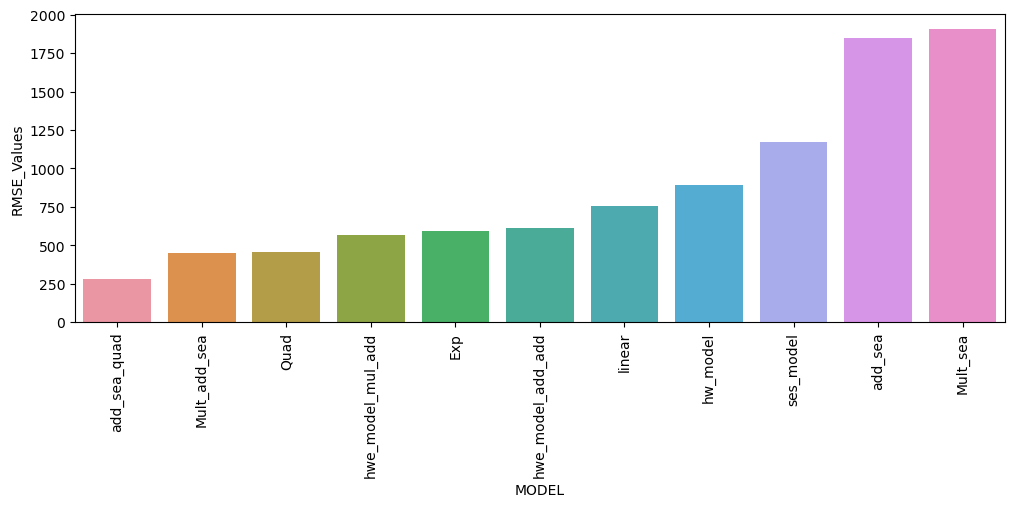

In [66]:

sns.barplot(table_rmse.MODEL , table_rmse.RMSE_Values)
plt.xticks(rotation = 90)
plt.show()

# Final Model by combining train and test

In [67]:

add_sea_Quad = smf.ols('Sales~t+t_squared+quarter_Q1 + quarter_Q2+ quarter_Q3+ quarter_Q4',data=coke1).fit()
pred= add_sea_Quad.predict(coke1.tail()) #predicting on historic data
forecast_df = pd.DataFrame()

forecast_df['actual_sales'] = coke1.Sales.tail()
forecast_df['Predicted_sales'] = pred 

forecast_df 

,actual_sales,Predicted_sales
37,4936.0,4705.724784
38,4895.0,4753.588072
39,4333.0,4557.724974
40,4194.0,4475.373006
41,5253.0,5257.826846


In [68]:

#creating new inputs for forecasting
new_df = pd.DataFrame() 
new_df['t'] = np.arange(43,50,1) 
new_df['t_squared'] = np.square(new_df.t)
new_df['quarter'] = ['Q3', 'Q4', 'Q1', 'Q2', 'Q3', 'Q4', 'Q1'] 
new_df = pd.get_dummies(new_df)
new_df

,t,t_squared,quarter_Q1,quarter_Q2,quarter_Q3,quarter_Q4
0,43,1849,0,0,1,0
1,44,1936,0,0,0,1
2,45,2025,1,0,0,0
3,46,2116,0,1,0,0
4,47,2209,0,0,1,0
5,48,2304,0,0,0,1
6,49,2401,1,0,0,0


In [69]:

add_sea_Quad = smf.ols('Sales~t+t_squared+quarter_Q1 + quarter_Q2+ quarter_Q3+ quarter_Q4',data=coke1).fit()
pred= add_sea_Quad.predict(new_df)  

new_df['forcasted'] = pred

new_df 

,t,t_squared,quarter_Q1,quarter_Q2,quarter_Q3,quarter_Q4,forcasted
0,43,1849,0,0,1,0,5319.754557
1,44,1936,0,0,0,1,5137.955882
2,45,2025,1,0,0,0,5069.668337
3,46,2116,0,1,0,0,5866.186600
4,47,2209,0,0,1,0,5942.178733
5,48,2304,0,0,0,1,5774.444481
6,49,2401,1,0,0,0,5720.221359


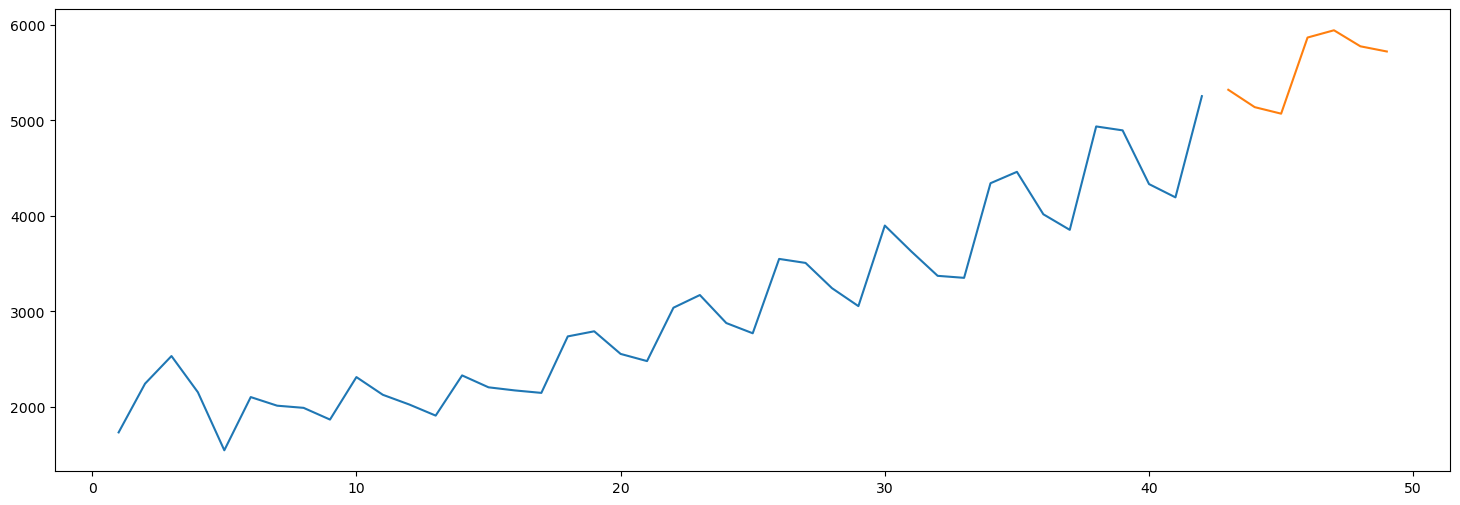

In [70]:

plt.figure(figsize=(18,6))
plt.plot(coke1.t , coke1.Sales)
plt.plot(new_df.t , new_df.forcasted)

# We created dummy variables for quarter feature and final model is based on Additive seasonality Quadratic.